# Estimating Urban Service Levels

First we load city boundaries, and partition the city in a grid

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import sys

sys.path.append("..")
import os
import urbanpy as up
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

## How are we going to estimate urban service level?

For each hexagon (centroid) we are going to generate isochrones for 30 minutes walk, with 5 minutes bands. For each band we are going to count the number of PoIs by categories.

### Isochrones Demo

#### Load Graphs

In [4]:
pos_id = 0
lima_boundaries = up.download.nominatim_osm("Lima, Peru", pos_id)

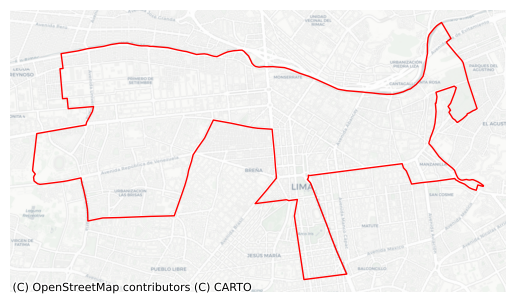

In [5]:
# Plot administrative limit
ax = lima_boundaries.plot(facecolor="none", edgecolor="r")
# Add a basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:4326")
ax.set_axis_off()

In [6]:
lima_downtown_graph = up.download.osmnx_graph(
    "polygon", "walk", geom=lima_boundaries.envelope[pos_id]
)

#### Generate isochrone from the centroid of the district

In [7]:
centroid = lima_boundaries.centroid[pos_id]

isochrones = up.routing.isochrone_from_graph(
    graph=lima_downtown_graph,
    locations=[[centroid.x, centroid.y]],
    time_range=[5, 10, 15, 20, 25],
    profile="walking",
)

#### Visualize isochrone

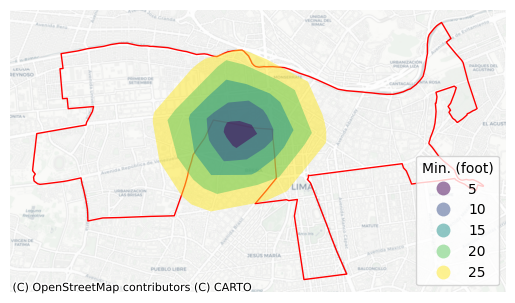

In [8]:
ax = lima_boundaries.to_crs(isochrones.crs).plot(facecolor="none", edgecolor="r")
# Plot the isochrone with categorical legend
isochrones.plot(
    "contour",
    alpha=0.5,
    cmap="viridis",
    ax=ax,
    legend=True,
    categorical=True,
    legend_kwds={"title": "Min. (foot)", "loc": "lower right"},
)
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:4326")

### Scale isochrone calculation up to every hexagon centroid in Lima's Downtown

In [9]:
lima_hexs = up.geom.gen_hexagons(resolution=9, city=lima_boundaries)

In [10]:
print("Number of hexagons generated:", lima_hexs.shape[0])

Number of hexagons generated: 172


In [11]:
lima_hexs["lon"] = lima_hexs.geometry.centroid.x
lima_hexs["lat"] = lima_hexs.geometry.centroid.y
hexs_centroids = lima_hexs[["lon", "lat"]].values

In [12]:
OUTPUT_FILE_PATH = "output/lima_downtown_isochrones_new.geojson"

In [13]:
if os.path.isfile(OUTPUT_FILE_PATH):
    downtown_isochrones = gpd.read_file(OUTPUT_FILE_PATH)
else:
    downtown_isochrones = up.routing.isochrone_from_graph(
        graph=lima_downtown_graph,
        locations=hexs_centroids,
        time_range=[5, 10, 15, 20, 25],
        profile="walking",
    )
    # Validate every geom is of the correct type
    if (downtown_isochrones.geom_type != "Polygon").sum() == 0:
        # Save output
        downtown_isochrones.to_file(OUTPUT_FILE_PATH, driver="GeoJSON")

In [14]:
downtown_isochrones.head()

,group_index,contour,geometry
0,0,25,"POLYGON ((-77.06459 -12.06489, -77.06711 -12.0..."
1,0,20,"POLYGON ((-77.06328 -12.06222, -77.07002 -12.0..."
2,0,15,"POLYGON ((-77.06363 -12.05867, -77.06918 -12.0..."
3,0,10,"POLYGON ((-77.06653 -12.05636, -77.06936 -12.0..."
4,0,5,"POLYGON ((-77.06704 -12.05262, -77.06954 -12.0..."


In [15]:
print("Number of isochrones generated (5 per hex):", downtown_isochrones.shape[0])

Number of isochrones generated (5 per hex): 860


#### Visualize an isochromes sample in a map

In [16]:
SAMPLE_SIZE = 5

### Create sample & filter time ranges for a better visualization

In [17]:
# Select a sample of isochrones
random_indices = np.random.choice(
    downtown_isochrones["group_index"].unique(), size=SAMPLE_SIZE, replace=False
)
sample_filter = downtown_isochrones["group_index"].isin(random_indices)

# Limit the number of bands to plot
timer_filter = downtown_isochrones["contour"].isin([5, 10, 15])

ischrones_rsample = downtown_isochrones[sample_filter & timer_filter]

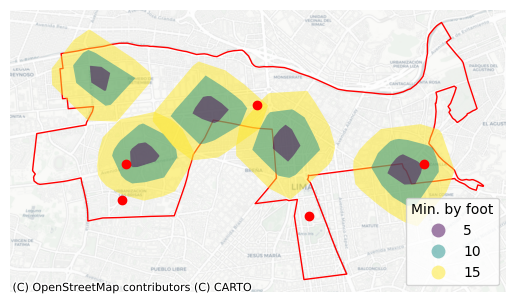

In [18]:
ax = lima_boundaries.to_crs(isochrones.crs).plot(facecolor="none", edgecolor="r")
ischrones_rsample.plot(
    "contour",
    alpha=0.5,
    ax=ax,
    categorical=True,
    legend=True,
    cmap="viridis",
    legend_kwds={"title": "Min. by foot", "loc": "lower right"},
)
lima_hexs.loc[random_indices].centroid.plot(color="r", ax=ax)
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:4326")

### Which PoIs categories we can use to calculate service levels?

TODO: Put link to OSM wiki & amenities content screenshot

In [19]:
from helpers import amenities

In [20]:
amenity_cats = list(amenities.keys())
print("Amenity Categories:", amenity_cats)

Amenity Categories: ['sustenance', 'education', 'transportation', 'financial', 'healthcare', 'entertainment', 'public_service', 'others']


In [21]:
# Put amenities in the overpass query format
ov_query_dict = {"amenity": [e for k, v in amenities.items() for e in v]}

In [22]:
# Get amenities (Point of Interest) from Overpass
gdf_pois, _ = up.download.overpass(
    type_of_data="node", query=ov_query_dict, mask=lima_boundaries
)

> We use `_` because when `type_of_data` is equal to `node` or `way` the second output is always `None`

In [23]:
# Put amenities in categorical format
poi_replace_dict = {e: k for k, v in amenities.items() for e in v}
# Group Points of Interest (PoIs) in categories
gdf_pois["poi_group"] = gdf_pois["poi_type"].replace(to_replace=poi_replace_dict)
# Set "Not asigned" if poi_type was not found in our categories
gdf_pois.loc[~gdf_pois["poi_group"].isin(amenity_cats), "pois_group"] = "Not assigned"

In [24]:
# Show information from obtained data
print("Number of amenities:", gdf_pois.shape[0])
print("Unique amenity types:", len(gdf_pois["poi_type"].unique()))

Number of amenities: 1720
Unique amenity types: 51


<Axes: title={'center': 'Number of amenities per category'}, ylabel='poi_group'>

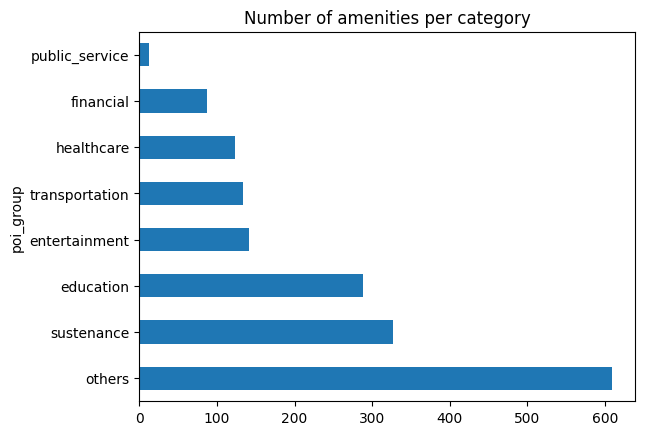

In [25]:
gdf_pois["poi_group"].value_counts().plot(
    kind="barh", title="Number of amenities per category"
)

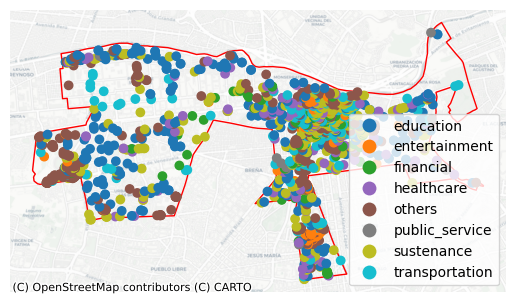

In [26]:
# Make a map of the obtained PoIs
ax = lima_boundaries.to_crs(isochrones.crs).plot(facecolor="none", edgecolor="r")
gdf_pois.plot("poi_group", legend=True, ax=ax)
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:4326")

In [27]:
# Create dummies (boolean) columns for each category
poi_group_dummies = pd.get_dummies(gdf_pois["poi_group"], prefix="poi_group")
gdf_pois = pd.concat([gdf_pois, poi_group_dummies], axis=1)

In [28]:
# Aggregate the the number of PoIs for each category per hexagon
lima_hexs_counts = up.geom.merge_shape_hex(
    hexs=lima_hexs,
    shape=gdf_pois,
    agg={"poi_group_" + cat: "sum" for cat in amenity_cats},
)

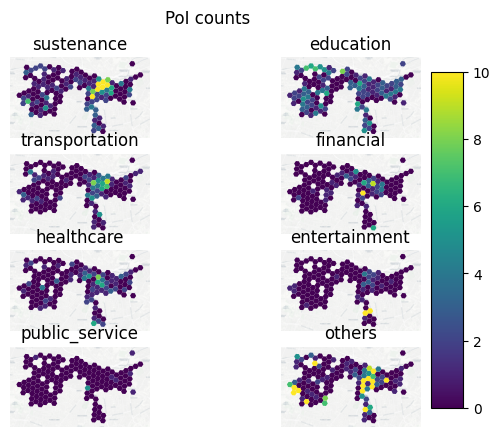

In [29]:
# Make a map of the number of PoIs for each category
fig, axes = plt.subplots(4, 2)
fig.suptitle("PoI counts")

# Make space for the colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

for i, ax in enumerate(axes.flat):
    # Only show legend for last map
    show_legend = bool(i == len(amenity_cats) - 1)
    lima_hexs_counts.plot(
        "poi_group_" + amenity_cats[i],
        legend=show_legend,
        vmin=0,
        vmax=10,
        cax=cbar_ax,
        ax=ax,
    )
    ax.set_title(amenity_cats[i])
    cx.add_basemap(
        ax, source=cx.providers.CartoDB.Positron, crs="EPSG:4326", attribution=""
    )
    ax.set_axis_off()

In [30]:
# Aggregate the the number of PoIs for each category per hexagon
downtown_isochrones_counts = up.geom.merge_shape_hex(
    hexs=downtown_isochrones,
    shape=gdf_pois,
    agg={"poi_group_" + cat: "sum" for cat in amenity_cats},
)

In [31]:
downtown_isochrones_counts.drop("geometry", axis=1).groupby(
    ["group_index", "contour"]
).mean()

poi_group_sustenance  poi_group_education   
group_index contour                                              
0           5                         1.0                  2.0  \
            10                        8.0                 15.0   
            15                       13.0                 35.0   
            20                       20.0                 52.0   
            25                       39.0                 91.0   
...                                   ...                  ...   
171         5                         0.0                  1.0   
            10                        3.0                 16.0   
            15                       14.0                 29.0   
            20                       23.0                 43.0   
            25                       36.0                 71.0   

                     poi_group_transportation  poi_group_financial   
group_index contour                                                  
0           5                             0.0                  0.0  \
            10                            1.0                  0.0   
            15                            6.0                  3.0   
            20                           12.0                  7.0   
            25                           20.0                  8.0   
...                                       ...                  ...   
171         5                             0.0                  0.0   
            10                            0.0                  0.0   
            15                            9.0                  2.0   
            20                           19.0                  3.0   
            25                           22.0                  3.0   

                     poi_group_healthcare  poi_group_entertainment   
group_index contour                                                  
0           5                         0.0                      0.0  \
            10                        2.0                      0.0   
            15                        7.0                      0.0   
            20                       11.0                      0.0   
            25                       16.0                      2.0   
...                                   ...                      ...   
171         5                         2.0                      1.0   
            10                        2.0                      1.0   
            15                        3.0                      3.0   
            20                        7.0                      4.0   
            25                       10.0                      4.0   

                     poi_group_public_service  poi_group_others  
group_index contour                                              
0           5                             0.0               1.0  
            10                            0.0               5.0  
            15                            0.0               7.0  
            20                            0.0              20.0  
            25                            0.0              46.0  
...                                       ...               ...  
171         5                             0.0               3.0  
            10                            0.0               9.0  
            15                            0.0             119.0  
            20                            0.0             206.0  
            25                            1.0             234.0  

[860 rows x 8 columns]

In [ ]:
# TODO: Separate a Point of Interest analysis notebook (hex counts)
# And a Accessibility analsis notebook with isochrones